## 梯度提升中的特征重要性

使用梯度提升的好处是，在建立了增强树之后，检索每个属性的重要性分数是相对简单的。


通常，重要性提供分数，该分数只是每个特征在模型内的增减决策树的构造中的有用性。使用决策树做出的关键决策的属性越多，其相对重要性就高。


对于每个数据集中的每个属性，明确计算此重要性，允许堆属性进行排名并进行相互比较

通常每个属性分割点改进表现度量的量来计算单个决策树的重要性，并由节点负责的观察数量加权，表现度量可以适用于选择分割点的纯度（基尼指数）或另一个更具体的误差函数。

然后，在模型中的所有决策树中对要素重要性进行平均。

经过训练的xgboost模型可以自动计算预测性建模问题的特征重要性。重要分数可以使用print(model.feature_importance_)打印输出，虽然在[微信公众号](https://mp.weixin.qq.com/s/F6p3ErjL3XJPxXwROXPwfg)里有分享，这里讲述细节
具体案例如下：

[0.07468373 0.2694981  0.09356754 0.09020481 0.08288945 0.15198407
 0.1017815  0.13539082]


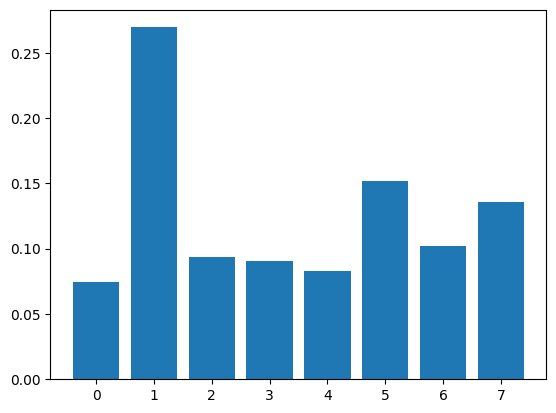

In [58]:
# 这里我们仍然基于糖尿病数据
# plot feature importance manually
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# load data
df = pd.read_csv('pima-indians-diabetes.csv')
x = df.iloc[:,0:8]
y = df.iloc[:,8]
# fit model on training data
model = XGBClassifier()
model.fit(x,y)
# feature importance
print(model.feature_importances_) 
# plot
plt.bar(range(len(model.feature_importances_)),model.feature_importances_)
plt.show()
# 这里要声明，横坐标依次是preg,plas,pres,skin,inus,mass,pedi,age,class

## 尝试保留列标签(*已成功*)

   preg  plas  pres  skin  inus  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1
['preg', 'plas', 'pres', 'skin', 'inus', 'mass', 'pedi', 'age', 'class']


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

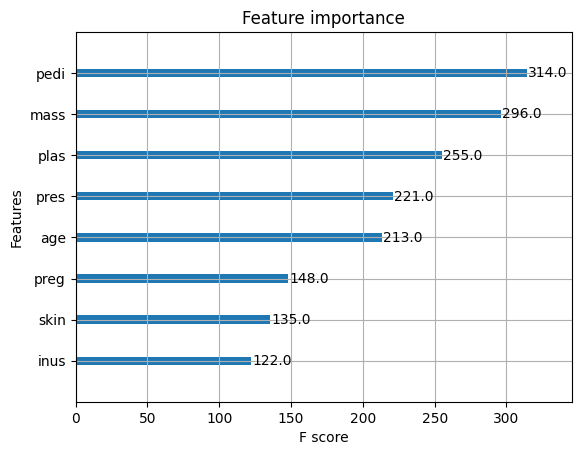

In [59]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('pima-indians-diabetes.csv')
print(df.head())
# 获取列标签
column_labels = df.columns.tolist()
print(column_labels)
# 将数据类型转换为numpy类型
x = df.iloc[:,0:8]
y = df.iloc[:,8]
# fit model on training data
model = XGBClassifier()
model.fit(x,y)
plot_importance(model)

使用手动绘制的图有点丑，因此我们在绘图之前执行重要性排序，有一个内置的绘图功能（plot.importance）可以帮助我们。


## 使用内置的xgboost功能重要性图

   preg  plas  pres  skin  inus  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

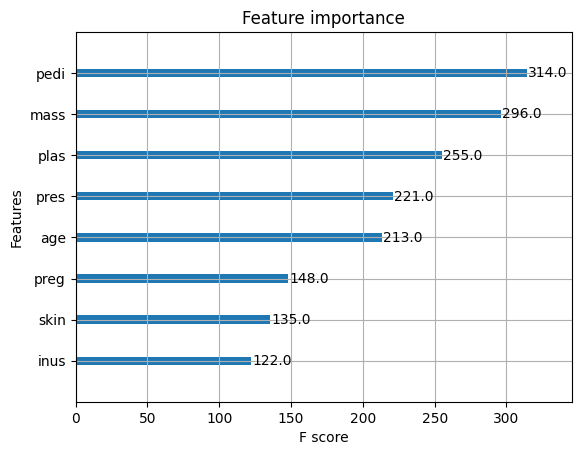

In [60]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('pima-indians-diabetes.csv')
print(df.head())
# 获取列标签
column_labels = df.columns.tolist()
# 将数据类型转换为numpy类型
x = df.iloc[:,0:8]
y = df.iloc[:,8]
# fit model on training data
model = XGBClassifier()
model.fit(x,y)
plot_importance(model)

## 使用xgboost功能重要性进行特征选择

特征重要性分数可以用于scikit-learn中的特征选择。


例如在整个训练数据集上训练的模型，然后，它可以使用阈值来决定选择哪些功能。在下面的实例中我们首先分别训练并评估整个训练数据集和测试数据集上的xgboost模型。


使用从训练数据集计算的要素重要性，然后我们将模型包装在SelectFromModel实例中，我们使用他来选择训练数据集上的也正，从所选特征子集训练模型，然后根据相同的特征选择方案评估测试集上的模型。

为了兴趣，我们可以测试多个阈值，以按功能重要性选择要素，具体而言，每个输入变量的特征重要性，基本上允许我们按重要性测试每个特征子集，从所有特征开始，已具有最重要特征的子集结束。

完整代码如下：

In [61]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
# load data
dataset = loadtxt('pima-indians-diabetes.csv',delimiter=",",skiprows=1)
# split data into x and y
x = dataset[:,0:8]
y = dataset[:,8]
# split data into train and test sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=7)
# fit model on training data
model = XGBClassifier()
model.fit(x_train,y_train)
# make predictions for test data and evaluation
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test,predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))
# fit model using each inportance as a threshold
thredsholds = sort(model.feature_importances_)
for thresh in thredsholds:
    # select features using threshold
    selection = SelectFromModel(model,threshold=thresh,prefit=True)
    select_x_train = selection.transform(x_train)
    # train model 
    selection_model = XGBClassifier()
    selection_model.fit(select_x_train,y_train)
    # eval model
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test,predictions)
    print("Thresh=%.3f,n=%d,Accuracy: %.2f%%" % (thresh,select_x_train.shape[1],accuracy*100))

Accuracy: 72.83%
Thresh=0.074,n=8,Accuracy: 72.83%
Thresh=0.085,n=7,Accuracy: 70.87%
Thresh=0.095,n=6,Accuracy: 71.26%
Thresh=0.108,n=5,Accuracy: 68.11%
Thresh=0.112,n=4,Accuracy: 70.87%
Thresh=0.134,n=3,Accuracy: 72.83%
Thresh=0.147,n=2,Accuracy: 71.65%
Thresh=0.244,n=1,Accuracy: 67.32%


我们可以看到模型的表现随着所选特征的数量而减少。
* 在这个问题上，需要权衡测试集合精度的特征，我们可以选择采用脚步复杂的模型（较少属性，如n = 3 ）,并接受估计精度的适度降低，从72.83%降到70.87%。
* 这可能时对这么小的数据集的一种清洗，但对于更大的数据集并且使用交叉验证作为模型评估方案可能是更有用的方法。